In [65]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA


In [66]:
# Load data
df = pd.read_parquet("processed_data/final_with_anomalies.parquet")

# %% 
# Create Store-Dept level features
store_dept_features = (
    df.groupby(["Store","Dept"])
      .agg(
          mean_sales=("Weekly_Sales", "mean"),
          sales_std=("Weekly_Sales", "std"),
          avg_pct_dev=("Pct_Deviation", "mean"),
          if_anomaly_rate=("IF_Anomaly", "mean"),
          high_conf_anomaly_rate=("High_Confidence_Anomaly", "mean"),
          markdown_rate=("Has_Markdown", "mean"),
          holiday_sales=("IsHoliday", "mean"),
          store_size=("Size", "first")
      )
      .reset_index()
)


In [67]:
# create a folder name processed_data/store_dept_segmentation/ if it does not exist
import os
os.makedirs("processed_data/store_dept_segmentation/", exist_ok=True)

In [68]:
store_dept_features.head()

,Store,Dept,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
0,1,1,22513.322937,9854.349032,0.007808,0.034965,0.000000,0.356643,0.06993,151315
1,1,2,46102.090420,3440.673222,-0.001273,0.020979,0.000000,0.356643,0.06993,151315
2,1,3,13150.478042,8708.978853,0.006062,0.020979,0.006993,0.356643,0.06993,151315
3,1,4,36964.154476,2930.698313,-0.000656,0.000000,0.000000,0.356643,0.06993,151315
4,1,5,24257.941119,11330.286495,0.000995,0.055944,0.000000,0.356643,0.06993,151315


In [69]:
seg_features = store_dept_features.columns.tolist()[2:] 
seg_features

['mean_sales',
 'sales_std',
 'avg_pct_dev',
 'if_anomaly_rate',
 'high_conf_anomaly_rate',
 'markdown_rate',
 'holiday_sales',
 'store_size']

In [70]:
store_dept_features.isnull().sum()

Store                      0
Dept                       0
mean_sales                 0
sales_std                 37
avg_pct_dev                0
if_anomaly_rate            0
high_conf_anomaly_rate     0
markdown_rate              0
holiday_sales              0
store_size                 0
dtype: int64

In [71]:
store_dept_features["sales_std"] = store_dept_features["sales_std"].fillna(0)

mean_sales 2.851410689894549


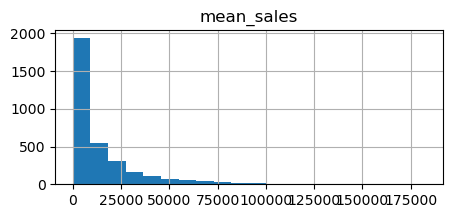

sales_std 4.255742607027794


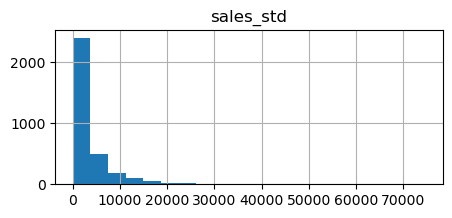

avg_pct_dev -16.751646007654507


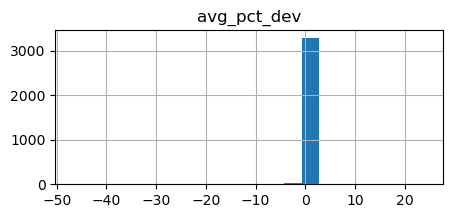

if_anomaly_rate 6.927083908154548


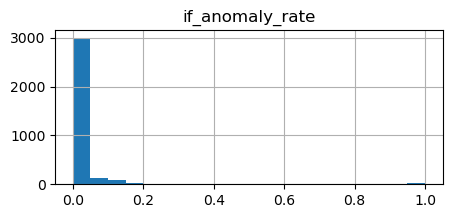

high_conf_anomaly_rate 24.85554536206815


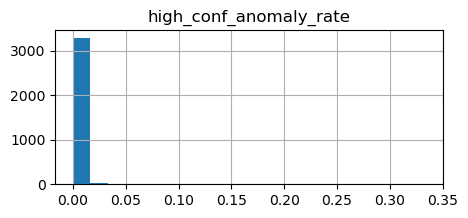

markdown_rate 2.351931518710828


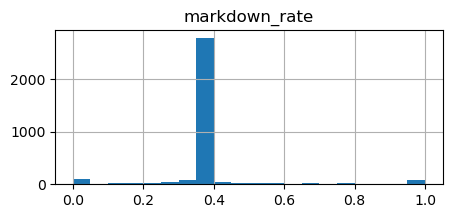

holiday_sales 10.288419127022085


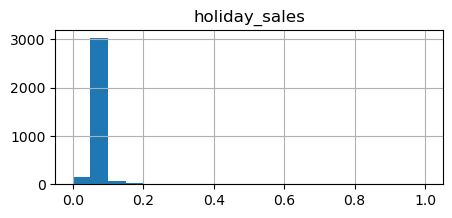

store_size -0.26815875223271796


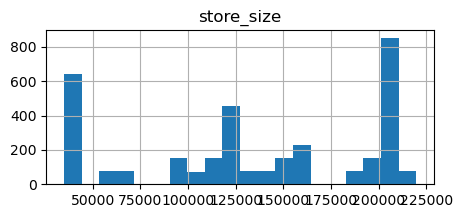

mean_sales 2.851410689894549
sales_std 4.255742607027794
avg_pct_dev -16.751646007654507
if_anomaly_rate 6.927083908154548
high_conf_anomaly_rate 24.85554536206815
markdown_rate 2.351931518710828
holiday_sales 10.288419127022085
store_size -0.26815875223271796


In [72]:
# %% 
# Inspect skewness and distributions for key features in the store_dept_features dataframe

for col in seg_features:
    print(col, store_dept_features[col].skew())
    plt.figure(figsize=(5,2))
    store_dept_features[col].hist(bins=20)
    plt.title(col)
    plt.show()

# %% 
# Print skewness summary for all features
for col in seg_features:
    print(col, store_dept_features[col].skew())

In [73]:
# %% 
# Apply Yeo-Johnson transformation to skewed features
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler

store_dept_seg = store_dept_features.copy()

# Features to transform with Yeo-Johnson
to_transform = ["mean_sales", "sales_std","avg_pct_dev" ,"if_anomaly_rate", 
                "high_conf_anomaly_rate", "markdown_rate", "holiday_sales"]

pt = PowerTransformer(method='yeo-johnson', standardize=False)
store_dept_seg[to_transform] = pt.fit_transform(store_dept_seg[to_transform])



mean_sales 0.010112323463238176


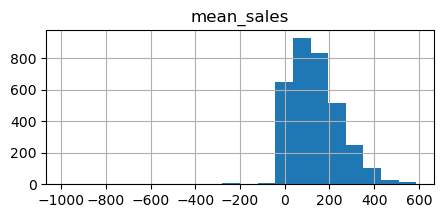

sales_std -0.05547263104856086


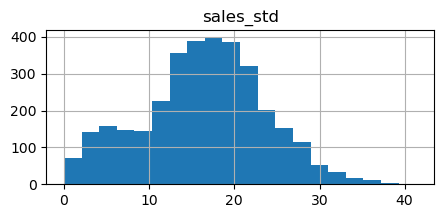

avg_pct_dev 0.520430635195172


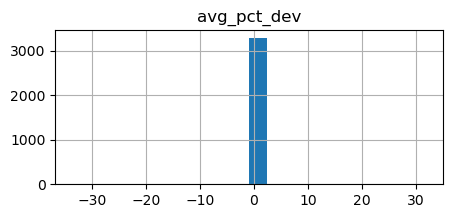

if_anomaly_rate 1.6483914039137857


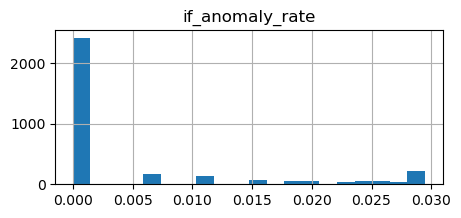

high_conf_anomaly_rate 4.627351470435674


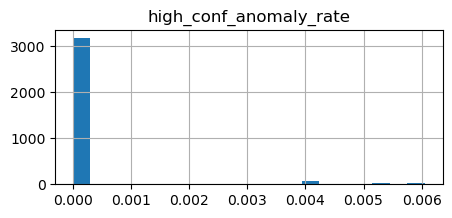

markdown_rate -0.23587735367335652


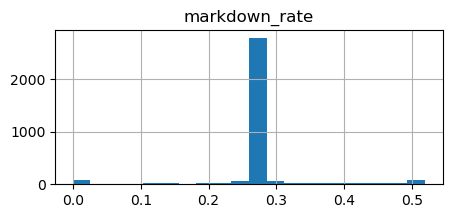

holiday_sales -0.9789767733150807


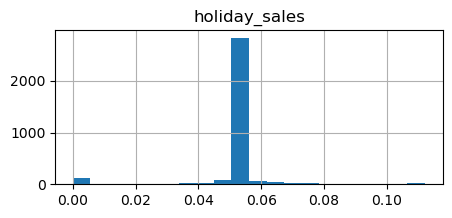

store_size -0.26815875223271796


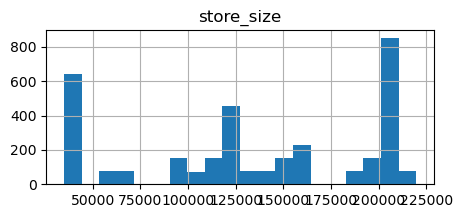

mean_sales 0.010112323463238176
sales_std -0.05547263104856086
avg_pct_dev 0.520430635195172
if_anomaly_rate 1.6483914039137857
high_conf_anomaly_rate 4.627351470435674
markdown_rate -0.23587735367335652
holiday_sales -0.9789767733150807
store_size -0.26815875223271796


In [74]:
# Check skewness after transformation
for col in seg_features:
    print(col, store_dept_seg[col].skew())
    plt.figure(figsize=(5,2))
    store_dept_seg[col].hist(bins=20)
    plt.title(col)
    plt.show()

for col in seg_features:
    print(col, store_dept_seg[col].skew())

In [75]:
# Scale all features for clustering

scaler = StandardScaler()
X_scaled_pt = scaler.fit_transform(store_dept_seg[seg_features])

In [76]:
X_scaled_pt.shape

(3331, 8)

In [77]:
# Check for Nan in X_scaled_pt

np.isnan(X_scaled_pt).sum()

np.int64(0)

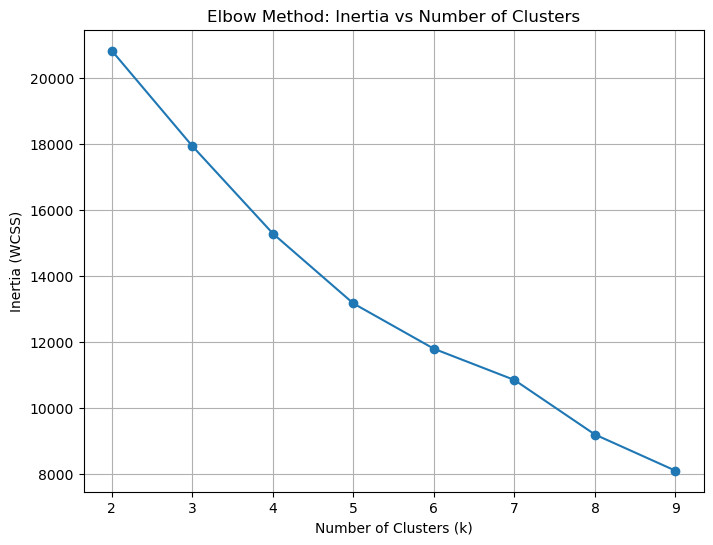

In [78]:
# %% 
# Elbow method for KMeans
inertia = []
k_values = range(2, 10)  # try k from 2 to 9

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled_pt)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# %% 

K = 5 or K = 7 might be good choices based on the elbow method

Silhouette scores: {2: 0.34820327333393297, 3: 0.3061241535204992, 4: 0.3684441161478491, 5: 0.31339528968043423, 6: 0.32451816232154135, 7: 0.3304058172969562, 8: 0.34345876800976705, 9: 0.34716561129672374}


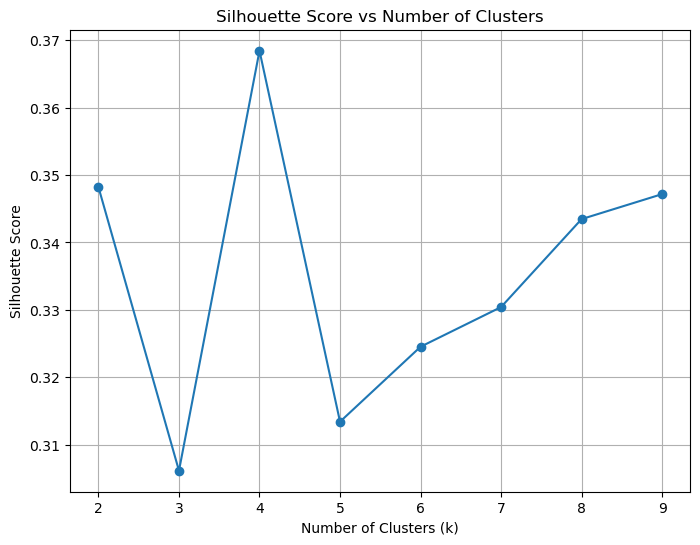

In [79]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil_scores = {}
k_values = range(2, 10)  # try k from 2 to 9

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_pt)
    sil_scores[k] = silhouette_score(X_scaled_pt, labels)

print("Silhouette scores:", sil_scores)

# plot silhouette scores
plt.figure(figsize=(8,6))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Based on the silhouette scores, k = 4 is the best choice with a silhouette score of 0.3684

In [80]:
# KMeans clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
store_dept_seg["Cluster_KMeans4"] = kmeans.fit_predict(X_scaled_pt)

print("Silhouette Score (KMeans k=4):", silhouette_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))

store_dept_profile_kmeans4 = store_dept_seg.groupby("Cluster_KMeans4")[seg_features].mean()


Silhouette Score (KMeans k=4): 0.3684441161478491
Davies-Bouldin Index: 1.071884652316308
Calinski-Harabasz Index: 824.208129621625


In [81]:
store_dept_profile_kmeans4


,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size
Cluster_KMeans4,,,,,,,,
0,190.904740,21.153832,0.086303,0.019923,0.004898,0.271356,0.053112,126282.135135
1,269.097906,25.069792,0.011581,0.019518,0.000000,0.267774,0.051011,166523.022355
2,104.398428,14.435901,-0.025472,0.000345,0.000000,0.272224,0.052629,127552.994519
3,-25.744130,2.772766,0.580972,0.000000,0.000000,0.210020,0.004031,94337.400000


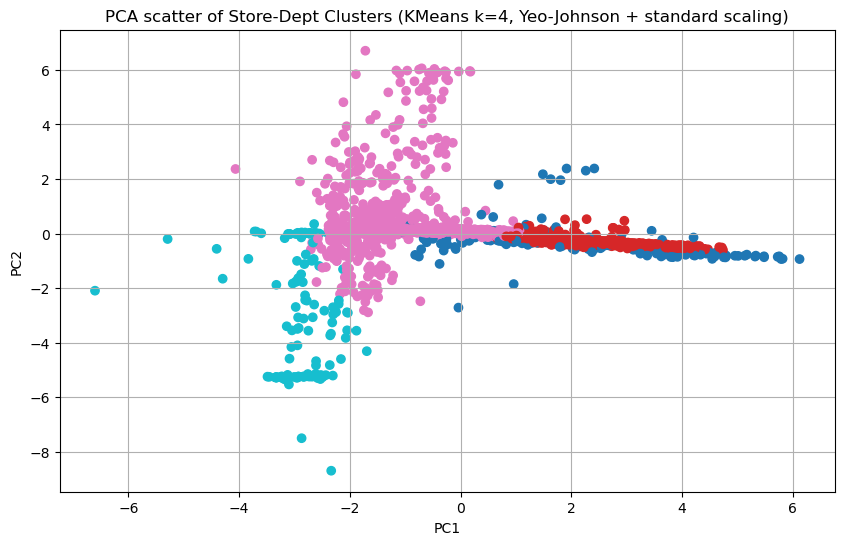

In [82]:
# PCA visualization
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(10,6))
plt.scatter(pc[:,0], pc[:,1], c=store_dept_seg["Cluster_KMeans4"], cmap="tab10")
# for i,(st,dp) in enumerate(zip(store_dept_seg["Store"], store_dept_seg["Dept"])):
#     plt.text(pc[i,0], pc[i,1], f"{st}-{dp}", fontsize=6)
plt.title("PCA scatter of Store-Dept Clusters (KMeans k=4, Yeo-Johnson + standard scaling)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [83]:
# calculate DBI and CHI for kmeans k=4
print("Silhouette Score (KMeans k=4):", silhouette_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))
print("Calinski-Harabasz Index:", calinski_harabasz_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]))

Silhouette Score (KMeans k=4): 0.3684441161478491
Davies-Bouldin Index: 1.071884652316308
Calinski-Harabasz Index: 824.208129621625


Agglomerative Clustering

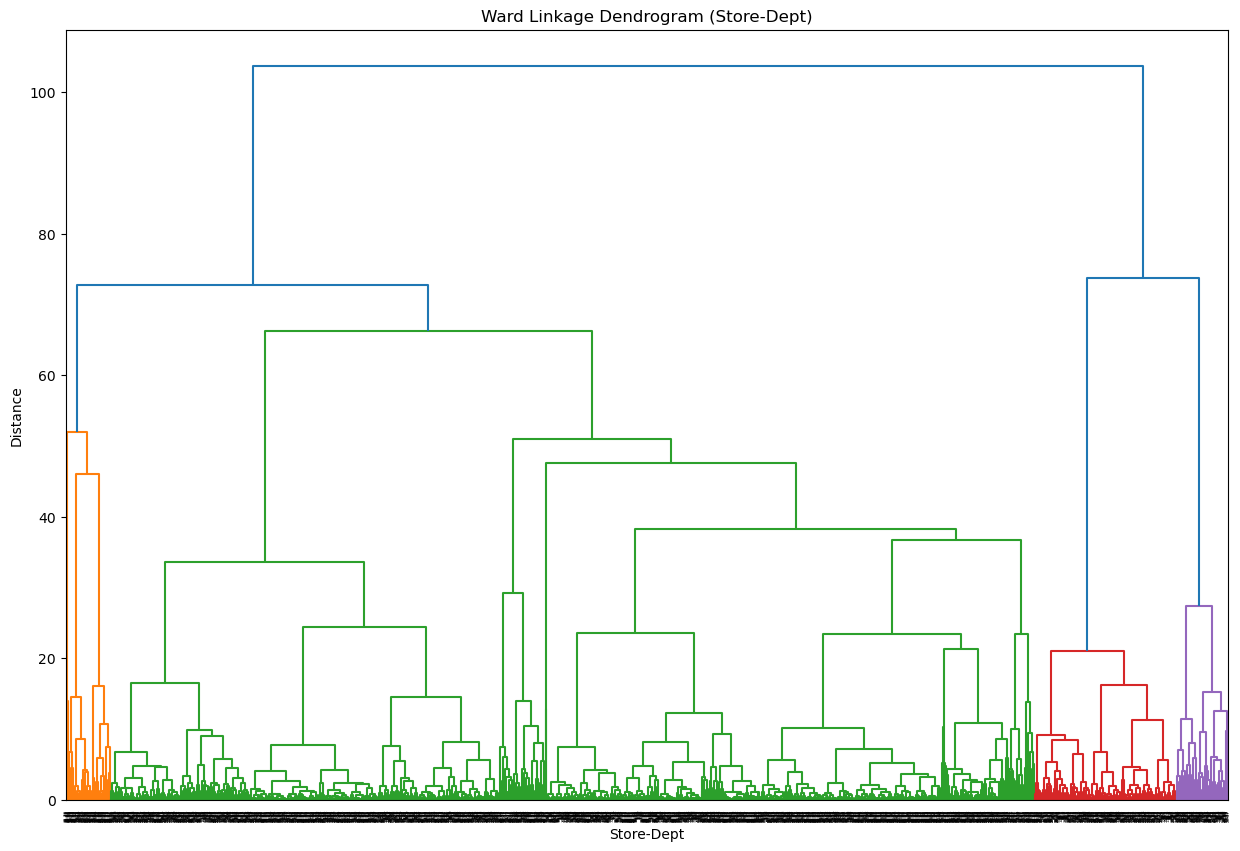

In [84]:
# Hierarchical clustering dendrogram , make the font size smaller for store-dept labels


import scipy.cluster.hierarchy as sch
Z = sch.linkage(X_scaled_pt, method='ward')
plt.figure(figsize=(15,10))
dn = sch.dendrogram(Z, 
                    labels=[f"{st}-{dp}" for st,dp in zip(store_dept_features["Store"], store_dept_features["Dept"])],
                    leaf_rotation=90,
                    leaf_font_size=3)  # Adjust font size here
plt.title("Ward Linkage Dendrogram (Store-Dept)")
plt.xlabel("Store-Dept")    
plt.ylabel("Distance")
plt.show()


From the dendrogram , it seems 9 differnt clusters can be a good choice. Even more clusters can be considered but it will be difficult to interpret the results. So I will choose 9 clusters for Agglomerative Clustering.

Other k values to check are 5 because it is the best for kmeans.

In [85]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

# linkage
Z = sch.linkage(X_scaled_pt, method='ward')

# try k=5 (from KMeans)
labels_hc5 = fcluster(Z, t=5, criterion='maxclust')

print("Silhouette (HC k=5):", silhouette_score(X_scaled_pt, labels_hc5))
print("DBI (HC k=5):", davies_bouldin_score(X_scaled_pt, labels_hc5))
print("CH (HC k=5):", calinski_harabasz_score(X_scaled_pt, labels_hc5))

Silhouette (HC k=5): 0.2474228368067311
DBI (HC k=5): 1.191189205713707
CH (HC k=5): 784.1694945699976


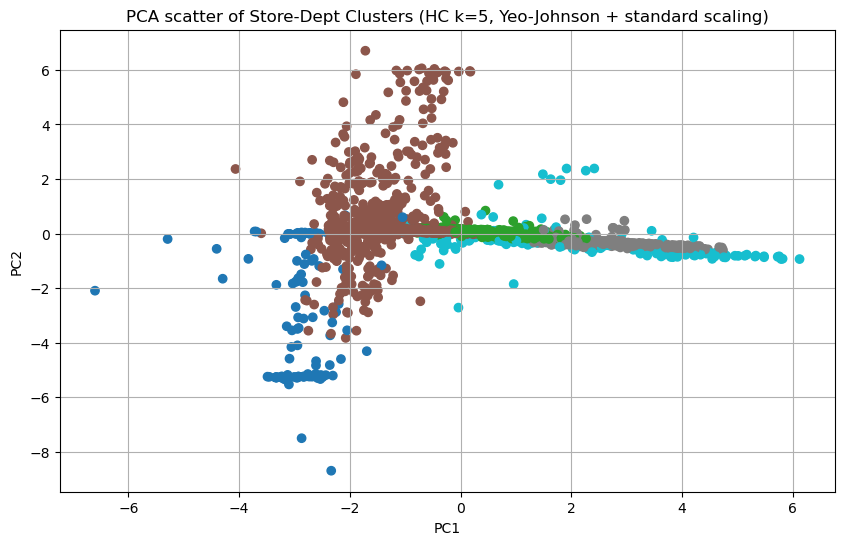

In [86]:
# Visualize HC k=5 clusters on PCA plot without store-dept labels for clarity
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(10,6))
plt.scatter(pc[:,0], pc[:,1], c=labels_hc5, cmap="tab10")
plt.title("PCA scatter of Store-Dept Clusters (HC k=5, Yeo-Johnson + standard scaling)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


Similar clustering as was given by kmeans with k=4

Silhouette (HC k=9): 0.28886941941863636
DBI (HC k=9): 0.8734814718092228
CH (HC k=9): 831.6192303278368


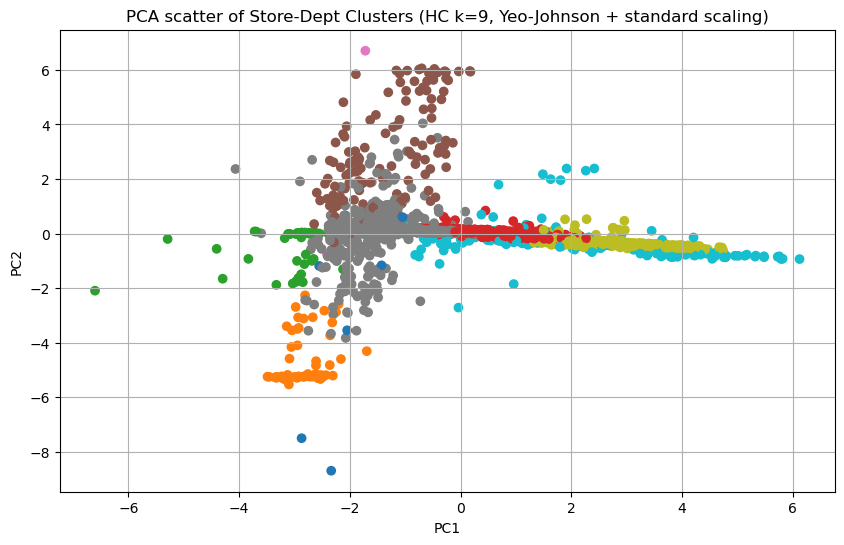

In [87]:
# Creating clusters with k=9 from the dendrogram
labels_hc9 = fcluster(Z, t=9, criterion='maxclust')
print("Silhouette (HC k=9):", silhouette_score(X_scaled_pt, labels_hc9))
print("DBI (HC k=9):", davies_bouldin_score(X_scaled_pt, labels_hc9))
print("CH (HC k=9):", calinski_harabasz_score(X_scaled_pt, labels_hc9))

# Visualize HC k=9 clusters on PCA plot without store-dept labels for clarity
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled_pt)
plt.figure(figsize=(10,6))
plt.scatter(pc[:,0], pc[:,1], c=labels_hc9, cmap="tab10")
plt.title("PCA scatter of Store-Dept Clusters (HC k=9, Yeo-Johnson + standard scaling)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [88]:
store_dept_seg.head()

,Store,Dept,mean_sales,sales_std,avg_pct_dev,if_anomaly_rate,high_conf_anomaly_rate,markdown_rate,holiday_sales,store_size,Cluster_KMeans4
0,1,1,221.677666,26.057197,0.007812,0.020294,-0.000000,0.26757,0.050806,151315,1
1,1,2,309.787101,20.219904,-0.001272,0.014904,-0.000000,0.26757,0.050806,151315,1
2,1,3,172.345080,25.307241,0.006064,0.014904,0.004141,0.26757,0.050806,151315,0
3,1,4,279.453104,19.431827,-0.000656,-0.000000,-0.000000,0.26757,0.050806,151315,2
4,1,5,229.549267,26.926625,0.000995,0.024832,-0.000000,0.26757,0.050806,151315,1


In [89]:
# add the cluster labels from differnt methods to the store_dept_seg dataframe
store_dept_seg["Cluster_HC5"] = labels_hc5
store_dept_seg["Cluster_HC9"] = labels_hc9


In [90]:
# Create a dataframe giving each method name as row and the corresponding silhouette score, DBI, CHI as columns for easy comparison
results_df = pd.DataFrame({
    "Method": ["KMeans k=4", "HC k=5", "HC k=9"],
    "Silhouette Score": [
        silhouette_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]),
        silhouette_score(X_scaled_pt, store_dept_seg["Cluster_HC5"]),
        silhouette_score(X_scaled_pt, store_dept_seg["Cluster_HC9"])
    ],
    "Davies-Bouldin Index": [
        davies_bouldin_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]),
        davies_bouldin_score(X_scaled_pt, store_dept_seg["Cluster_HC5"]),
        davies_bouldin_score(X_scaled_pt, store_dept_seg["Cluster_HC9"])
    ],
    "Calinski-Harabasz Index": [
        calinski_harabasz_score(X_scaled_pt, store_dept_seg["Cluster_KMeans4"]),
        calinski_harabasz_score(X_scaled_pt, store_dept_seg["Cluster_HC5"]),
        calinski_harabasz_score(X_scaled_pt, store_dept_seg["Cluster_HC9"])
    ]
})

results_df

,Method,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,KMeans k=4,0.368444,1.071885,824.208130
1,HC k=5,0.247423,1.191189,784.169495
2,HC k=9,0.288869,0.873481,831.619230


In [91]:
# save all results in processed_data/store_dept_segmentation/ folder 

store_dept_seg.to_parquet("processed_data/store_dept_segmentation/store_dept_seg.parquet", index=False)
store_dept_profile_kmeans4.to_parquet("processed_data/store_dept_segmentation/store_dept_profile_kmeans4.parquet", index=True)
# saving the results_df as well
results_df.to_csv("processed_data/store_dept_segmentation/clustering_results_comparison.csv", index=False)

The Best Clustering is Given by Kmeans clustering with k = 4. It has the highest silhouette score and lowest Davies-Bouldin Index. The clusters are also well separated in the PCA scatter plot.